In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import math
import matplotlib.colors as mcolors
from scipy import signal
from matplotlib.patches import Rectangle


import sys

sys.path.append("../lib/")
import matplotlib.pyplot as plt
from figparams import *

plt.rcParams.update(rc_params)
from utils import *

import average_envelope as env

clight = 299792458.0  # Speed of light in m/s
L = 8.3  # Arm length of LISA in seconds
year = 31557600.0  # Seconds in a year
day = 86400
chunk_duration = 15 * day
n_chunks = 24
Armlength = 2.5e9 / clight

colors = get_colormap_colors(24, "plasma")


In [2]:
def average_log_chunks(freqs, data, response, num_bins=50):
    """
    Averages data in logarithmic bins.

    Args:
        freqs (array): Frequency array.
        data (array): Data array.
        response (array): Response array.
        num_bins (int): Number of bins.

    Returns:
        tuple: Averaged frequency, data, response, and count arrays.
    """
    freqs = np.asarray(freqs)
    data = np.asarray(data)
    response = np.asarray(response)

    log_min = np.log10(np.min(freqs[freqs > 0]))
    log_max = np.log10(np.max(freqs))
    log_bins = np.logspace(log_min, log_max, num_bins + 1)

    f_avg, d_avg, r_avg, count = [], [], [], []

    for i in range(num_bins):
        mask = (freqs >= log_bins[i]) & (freqs < log_bins[i + 1])
        if np.any(mask):
            f_avg.append(0.5 * (freqs[mask][0] + freqs[mask][-1]))
            d_avg.append(np.mean(data[mask]))
            r_avg.append(np.mean(response[mask]))
            count.append(np.sum(mask))

    return np.array(f_avg), np.array(d_avg), np.array(r_avg), np.array(count)


def acc(freq, T, A=2.4):
    # fs = 0.5
    # fknee = 0.4*10**-3 #2*10**-3
    # z = np.exp(1j*2*np.pi*freq/fs)
    # fmin = 1/T
    # mod = np.abs((2*np.pi*fmin)/(1 - np.exp(-2*np.pi*fmin/fs)*z**-1))

    psd = (
        (A * 10**-15) ** 2
        * (1 + (0.4 * 10**-3 / freq) ** 2)
        / (2 * np.pi * freq * clight) ** 2
    )
    # (A*10**-15)**2*(fknee/(np.pi*clight))**2*mod**2*(1/(fmin*fs))**2*np.abs(1/(1-z**-1))**2*(2*np.pi/fs)**2 + (A*10**-15/(np.pi*clight))**2*mod**2*(1/(fmin*fs))**2
    return psd


def oms(freq, T, P=7.9):
    fs = 0.5
    fknee = 2 * 10**-3
    z = np.exp(1j * 2 * np.pi * freq / fs)
    fmin = 1 / T
    mod = np.abs((2 * np.pi * fmin) / (1 - np.exp(-2 * np.pi * fmin / fs) * z**-1))
    psd = (P * 10**-12) ** 2 * (2 * np.pi * fknee**2 / clight) ** 2 * (
        1 / (fs * fmin)
    ) ** 2 * mod**2 + (P * 10**-12) ** 2 * (fs / clight) ** 2 * np.sin(
        2 * np.pi * freq / fs
    ) ** 2
    return psd


def Cxx(freq):
    w = 2 * np.pi * freq * Armlength
    return 32 * np.sin(w) ** 2 * np.sin(2 * w) ** 2


def psd_AE_acc(freq, T, A=2.4):
    Sacc = acc(freq, T, A)
    w = 2 * np.pi * freq * Armlength

    tr_acc = Cxx(freq) * 4 * (1 + np.cos(w) + np.cos(w))

    return Sacc * tr_acc


def psd_AE_opt(f, T, P=7.9):
    Soms = oms(f, T, P)
    w = 2 * np.pi * f * Armlength

    tr_oms = Cxx(f) * (2 + np.cos(w))

    return Soms * tr_oms


def psd_AE(f, T, A=2.4, P=7.9):
    return psd_AE_acc(f, T, A) + psd_AE_opt(f, T, P)


def galactic_foreground_time(freqs, par, injected=False, t1=0, t2=0, tdi=0, gen2=False):
    """
    Galactic foreground model for gravitational wave signal with time dependence.
    https://arxiv.org/abs/2410.08274, https://arxiv.org/abs/2410.08263

    Args:
        freqs (array): Frequency array.
        injected (bool): If True, uses injected parameters.
        par (dict): Parameters for the model.
        t1 (float): Start time for the envelope.
        t2 (float): End time for the envelope.
        tdi (int): TDI channel (0 = A, 1 = E).
    Returns:
        array: Power spectral density.
    """

    alpha = par["alpha"]
    amp = par["amp"]
    fknee = par["fknee"]
    fr1 = par["fr1"]
    fr2 = par["fr2"]
    lat = par["lat"]
    long = par["long"]
    psi = par["psi"]
    s1 = par["s1"]
    s2 = par["s2"]

    amp_time = env.average_envelopes_gaussian(
        lat,
        long,
        s1,
        s2,
        psi,
        t1,
        t2,
        LISA_Orbital_Freq=1 / year,
        alpha0=0.0,
        beta0=0.0,
        tdi=tdi,
    )

    Sh = (
        amp_time
        * 10**amp
        * np.exp(-((freqs / 10**fr1) ** alpha))
        * (freqs ** (-7.0 / 3.0))
        * 0.5
        * (1.0 + np.tanh(-(freqs - 10**fknee) / 10**fr2))
    )

    # LISA arm length and angular frequency
    omega = 2.0 * np.pi * freqs
    x = omega * L
    tr = (x) ** 2 * np.sin(x) ** 2
    Sh *= tr

    factor_tdi2 = 4 * np.sin(2 * x) ** 2

    # Fallback for non-JAX environments
    Sh = Sh * factor_tdi2 if gen2 else Sh

    return Sh


def spectrogram(data, fs, nperseg):
    f, t, Sxx = signal.spectrogram(data, fs=fs, nperseg=nperseg, noverlap=0)
    return f, t, Sxx

In [3]:
posterior = np.load("../data/first_year_yorsh/result_gamma.npz", allow_pickle=True)[
    "posterior"
][()]["chain"]
label = ["alpha", "amp", "fknee", "fr1", "fr2", "lat", "long", "psi", "s1", "s2"]
# create a discotnary with keys as label and values as posterior
samples_gamma = {}
for i, name in enumerate(label):
    samples_gamma[name] = posterior[:, i]
T1, T2 = np.loadtxt("../data/first_year_yorsh/time_interval.txt")


In [4]:
# Open the HDF5 file
file = "yorsh_1b-1_training_sobhb.h5"
with h5py.File("../data/first_year_yorsh/" + file, "r") as f:
    # List all groups in the file
    print("Keys in the file:", list(f.keys()))

    # get confnoise
    confnoise = f["confnoise"]
    t = confnoise["tdi"]["t"][:]
    X = confnoise["tdi"]["X"][:]
    Y = confnoise["tdi"]["Y"][:]
    Z = confnoise["tdi"]["Z"][:]

    noise = f["instnoise"]
    # print("Keys in the instru group:", list(noise.keys()))
    Xinst = noise["tdi"]["X"][:]
    Yinst = noise["tdi"]["Y"][:]
    Zinst = noise["tdi"]["Z"][:]


def AET(X, Y, Z):
    A = (Z - X) / math.sqrt(2.0)
    E = (X - 2.0 * Y + Z) / math.sqrt(6.0)
    T = (X + Y + Z) / math.sqrt(3.0)
    return A, E, T


A, E, T = AET(X[: len(X) // 2], Y[: len(X) // 2], Z[: len(X) // 2])
t = t[: len(X) // 2]
Ainst, Einst, Tinst = AET(
    Xinst[: len(Xinst) // 2], Yinst[: len(Xinst) // 2], Zinst[: len(Xinst) // 2]
)
dt = t[1] - t[0]


Keys in the file: ['confnoise', 'header', 'instnoise', 'instru', 'noisefree', 'sky']


In [5]:
chunk_ind = np.linspace(1, 24, n_chunks, dtype=int)
time_chunk = np.linspace(chunk_duration, n_chunks * chunk_duration, n_chunks, dtype=int)
point = chunk_duration / dt
tot_point = int(point * n_chunks)
nch = 24
monthA = np.split(A[:tot_point], nch)
monthE = np.split(E[:tot_point], nch)
tmonth = np.split(t[:tot_point], nch)

/tmp/ipykernel_583941/4279557466.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tot_point = int(point * n_chunks)


In [6]:
fs = 1 / dt
# Compute the spectrogram
fdata2, t2, Sxx2 = spectrogram(A.T[0], fs=fs, nperseg=int(tmonth[0][-1] / dt))
fmin, fmax = 10**-4, 10**-2.5
# Apply frequency mask
freq_mask = (fdata2 >= fmin) & (fdata2 <= fmax)
f_sel2 = fdata2[freq_mask]
Sxx_sel2 = Sxx2[freq_mask, :]
# Convert to log scale
log_f_sel2 = np.log10(f_sel2)
Sxx_log2 = np.log10(Sxx_sel2)

/tmp/ipykernel_583941/1168028958.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fdata2, t2, Sxx2 = spectrogram(A.T[0], fs=fs, nperseg=int(tmonth[0][-1] / dt))


In [ ]:
spectra = []
spec_full = []
for j in range(len(T1)):
    TOBS = tmonth[1][0]
    window = np.kaiser(len(monthA[j]), 30)
    W = np.sum(window**2)
    fs = 1 / dt
    factor = np.sqrt(2 / (W * fs))
    Af_month = np.fft.rfft(monthA[j].T[0] * window) * factor

    freqs = np.arange(0, 0.5 / (dt) + 1 / tmonth[0][-1], 1 / tmonth[0][-1])

    N = len(monthA[j])
    nseg = 1000
    f, dA, RA, c = average_log_chunks(
        freqs, np.abs(Af_month) ** 2, np.zeros_like(freqs), nseg
    )
    spec_full.append(np.abs(Af_month) ** 2)
    spectra.append(dA)


spec_med = []
spec_down = []
spec_up = []

freq = np.logspace(np.log10(fmin), np.log10(fmax), 1000)

for i in range(len(T1)):
    spec = []
    for j in range(len(f)):
        spec.append(
            galactic_foreground_time(
                f[j],
                samples_gamma,
                injected=False,
                t1=T1[i],
                t2=T2[i],
                tdi=0,
                gen2=True,
            )
        )
        # spec.append(galaxy_spectrum(alpha, amp, logfkn, logf1, logf2, lat, long, s1, s2, psi, t1=T1[i], t2=T2[i], f=freq[j]))

    spec_med.append(np.median(spec, axis=1))
    spec_down.append(np.percentile(spec, 5, axis=1))
    spec_up.append(np.percentile(spec, 95, axis=1))
spec_med = np.array(spec_med)
spec_down = np.array(spec_down)
spec_up = np.array(spec_up)


/tmp/ipykernel_583941/919241404.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  freqs = np.arange(0, 0.5 / (dt) + 1 / tmonth[0][-1], 1 / tmonth[0][-1])


/tmp/ipykernel_561172/1350694932.py:44: RuntimeWarning: divide by zero encountered in divide
  * (1 + (0.4 * 10**-3 / freq) ** 2)
/tmp/ipykernel_561172/1350694932.py:76: RuntimeWarning: invalid value encountered in multiply
  return Sacc * tr_acc
/tmp/ipykernel_561172/4145691379.py:21: RuntimeWarning: divide by zero encountered in log10
  Sxx_logmodel = np.log10(Sxx_model)


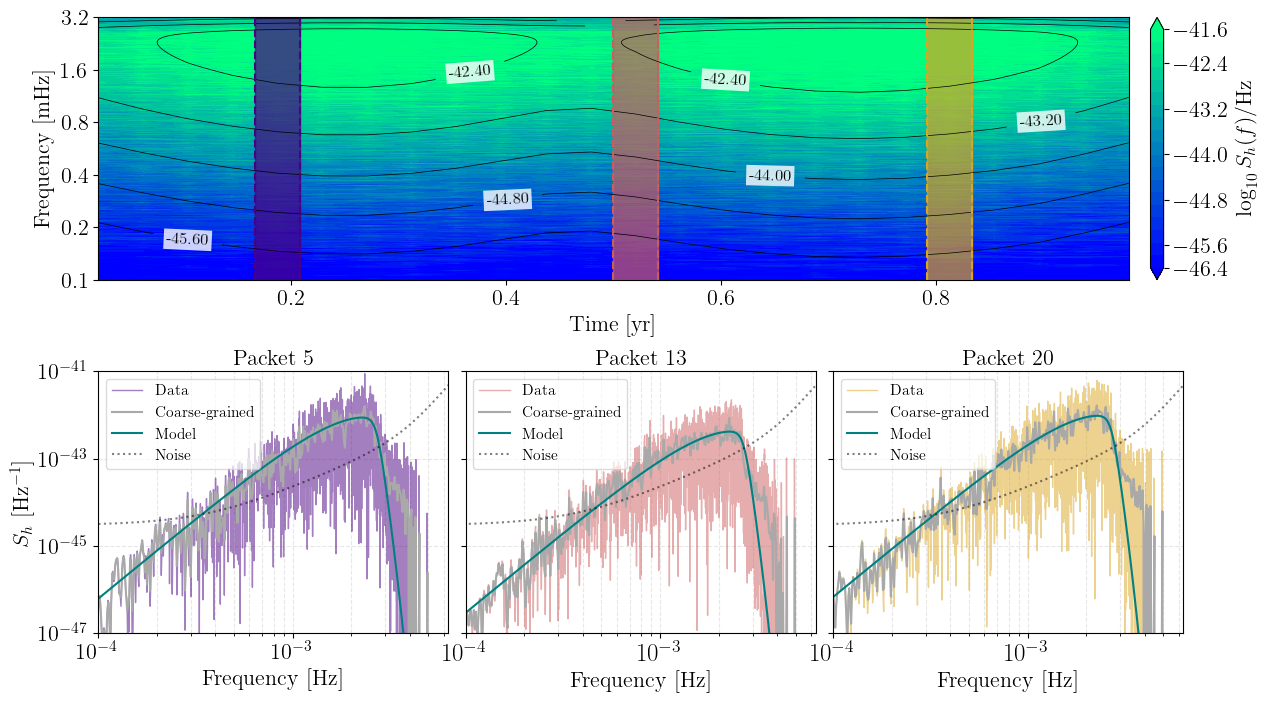

In [ ]:
noise = psd_AE(freqs, T=year, A=2.4, P=7.9)

# Select packets 5, 10, and 15 (indices 4, 9, 14 in 0-based indexing)
selected_packets = [4, 12, 19]  # packets 5, 10, 15
n_packets = len(selected_packets)

# Create figure with subplots - spectrogram on top, spectra below
fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(2, n_packets, height_ratios=[1.0, 1.0], hspace=0.35, wspace=0.05)

# Top panel: Spectrogram (spans all columns)
ax_spec = fig.add_subplot(gs[0, :])

# Frequency bounds (in Hz)
fmin = 10**-4
fmax = 10**-2.5

# Model spectrogram setup
tmodel = 0.5 * (T1 + T2)
Sxx_model = spec_up.T
Sxx_logmodel = np.log10(Sxx_model)

# Create common normalization
vmin = -46
vmax = -41.8
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# Define contour levels
levels = np.linspace(vmin, vmax, 20)
levels_c = np.array([-45.6, -44.8, -44.0, -43.2, -42.4])

# Plot the data as filled contours
im = ax_spec.contourf(
    t2 / (86400 * 15 * 24),
    log_f_sel2,
    Sxx_log2,
    levels=levels,
    origin="lower",
    extend="both",
    norm=norm,
    alpha=1,
    cmap="winter",
)

# Overlay the model as contour lines
contour_lines = ax_spec.contour(
    tmodel / (86400 * 15 * 24),
    np.log10(f),
    Sxx_logmodel,
    levels=levels_c,
    colors="k",
    linewidths=0.5,
    linestyles="solid",
    alpha=1,
)

# Add labels to contour lines
y_max_label = np.log10(2.5e-03)
labels = ax_spec.clabel(
    contour_lines,
    inline=True,
    fontsize=12,
    fmt="%0.2f",
    colors="k",
    inline_spacing=15,
    rightside_up=True,
)

# Add a box around each label
for txt in labels:
    txt.set_bbox(dict(facecolor="white", edgecolor="none", pad=2, alpha=0.8))

for txt in contour_lines.labelTexts:
    label_pos = txt.get_position()
    if label_pos[1] > y_max_label:
        txt.set_visible(False)
    else:
        pass
        # txt.set_path_effects(
        #     [
        #         path_effects.Stroke(linewidth=0.5),#, foreground="orange"),
        #         path_effects.Normal(),
        #     ]
        # )

# Add rectangular masks for selected packets showing T1 to T2 range

for idx, packet_idx in enumerate(selected_packets):
    t1_packet = T1[packet_idx] / (86400 * 15 * 24)
    t2_packet = T2[packet_idx] / (86400 * 15 * 24)
    width = t2_packet - t1_packet

    # Add rectangle spanning from T1 to T2
    rect = Rectangle(
        (t1_packet, np.log10(fmin)),
        width,
        np.log10(fmax) - np.log10(fmin),
        linewidth=1.0,
        edgecolor=colors[packet_idx],
        facecolor=colors[packet_idx],
        alpha=0.7,
        label=f"Packet {packet_idx + 1}",
    )
    ax_spec.add_patch(rect)

    # Add vertical lines at T1 and T2
    ax_spec.axvline(
        t1_packet, color=colors[packet_idx], linestyle="--", linewidth=1.5, alpha=1
    )
    ax_spec.axvline(
        t2_packet, color=colors[packet_idx], linestyle="--", linewidth=1.5, alpha=1
    )

# Set y-axis
ax_spec.set_ylim(np.log10(fmin), np.log10(fmax))
yticks = np.geomspace(fmin, fmax, num=6)
yticks_log = np.log10(yticks)
ax_spec.set_yticks(yticks_log)
ax_spec.set_yticklabels([f"{1000 * y:.1f}" for y in yticks])
ax_spec.set_ylabel("Frequency [mHz]", fontsize=16)
ax_spec.set_xlabel("Time [yr]", fontsize=16)
ax_spec.tick_params(axis="y", labelsize=16)
ax_spec.tick_params(axis="x", labelsize=16)
# ax_spec.legend(loc='upper right', fontsize=11, framealpha=0.9)

# Add colorbar
cbar = fig.colorbar(im, ax=ax_spec, orientation="vertical", fraction=0.03, pad=0.02)
cbar.set_label("$\\log_{10} S_h (f)/{\\rm Hz}$", fontsize=16)
# Set colorbar ticklabels formatting to 1 decimal place
cbar.ax.yaxis.set_major_formatter(plt.FormatStrFormatter("%.1f"))
# Set ticks fontsize to 14
cbar.ax.tick_params(labelsize=16)
# Reduce the number of ticks on the colorbar
cbar.locator = plt.MaxNLocator(nbins=6)
cbar.update_ticks()

# Bottom panels: Spectra for selected packets
for panel_idx, packet_idx in enumerate(selected_packets):
    ax = fig.add_subplot(gs[1, panel_idx])

    ax.loglog(
        freqs,
        spec_full[packet_idx],
        label="Data",
        color=colors[packet_idx],
        linewidth=1.0,
        alpha=0.5,
    )
    ax.loglog(
        f,
        spectra[packet_idx],
        label="Coarse-grained",
        color="darkgray",
        alpha=1,
        # linewidth=1,
    )
    ax.plot(
        f,
        spec_med[packet_idx],
        color="teal",
        label="Model",
        # linewidth=2.5
    )
    ax.loglog(
        freqs,
        noise,
        color="k",
        alpha=0.5,
        linestyle=":",
        # linewidth=1.5,
        label="Noise",
    )

    # # Add colored border to match the vertical line
    # for spine in ax.spines.values():
    #     spine.set_edgecolor(colors[packet_idx])
    #     spine.set_linewidth(3)

    # Add time range information to title
    t1_years = T1[packet_idx] / (86400 * 15 * 24)
    t2_years = T2[packet_idx] / (86400 * 15 * 24)
    ax.set_title(f"Packet {packet_idx + 1}", color="k", pad=5, fontsize=16)
    ax.set_xlabel("Frequency [Hz]", fontsize=16)

    if panel_idx == 0:
        ax.set_ylabel(r"$S_h$ [Hz$^{-1}$]", fontsize=16)
        ax.tick_params(axis="y", labelsize=16)
        ax.tick_params(axis="x", labelsize=16)

    ax.set_xlim(1e-4, 10**-2.2)
    ax.set_ylim(1e-47, 1e-41)
    # Remove y ticks and labels for middle and right panel
    if panel_idx != 0:
        ax.set_yticklabels([])

    ax.grid(True, alpha=0.3, which="both", linestyle="--")
    ax.legend(loc="upper left", fontsize=11, framealpha=0.7)

# fig.suptitle('Spectrogram with Spectral Time Slices', fontsize=16, fontweight='bold', y=0.98)
plt.savefig("../plots/Figure10.pdf", dpi=300, bbox_inches="tight")
plt.show()